# Using the selected countries quarterly data:
## Understanding the relationship/s between MEVs

This notebook starts from The second plan, to see plan 1 refer to v01

---------------------
**First plan** is as follow:
The plan is as follow:
- Look at and investigate correlation:
  * Pairwise correlation (topic agnostic)
  * Pairwise correlation per topic 
- GLM: US GDP prediction using the other features
- Using Multiple linear regression: US GDP with all the other features
- Clustering
  * Normal clustering NOT time series one

  ------------------------------------------------------------

**Second Plan** is to selected countries such as US, Canada, UK, Germany, Switzerland and South Korea and use their data to build a forcasting model. Then use this model to predict/test other countries MEVs such as Nigeria, UAE...etc.

The plan is as follow:
- Look at and investigate correlation:
  * Pairwise correlation (topic agnostic)
  * Pairwise correlation per topic 
- Using Multiple linear regression: US GDP with all the other features
    - Imputation
    - Regularization
- Decision Tree

**Import Libraries**

In [129]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st



from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Libraries:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from dataprep.eda import create_report
from dataprep.eda import plot, plot_correlation, plot_missing

**Upload datasets**

In [130]:
mev = pd.read_csv('MEV_Selected_top_countries.csv',sep=";")

In [131]:
mev.head()

,Date,Korea_Nominal_GDP,Korea_CPI,Korea_Unemployment_rate,Korea_Residential_property_index,US_Nominal_GDP,US_CPI,US_Unemployment_rate,US_Residential_property_index,Canada_Nominal_GDP,...,Switzerland_Residential_property_index,UK_Nominal_GDP,UK_CPI,UK_Unemployment_rate,UK_Residential_property_index,D_Nominal_GDP,D_CPI,D_Unemployment_rate,D_Residential_property_index,Unnamed: 25
0,1975-01-01,2370600,9.012579,NaN,63.2476,1616.116,52.566667,8.27,60.02,167572,...,36.2205,26777,14.043801,3.969991,5.4978,NaN,39.142725,3.6,128.1556,NaN
1,1975-04-01,2583900,9.738219,NaN,65.3178,1651.853,53.200000,8.87,60.96,173748,...,35.7642,28090,15.371077,4.339689,5.6187,NaN,39.903834,4.2,127.2398,NaN
2,1975-07-01,2690300,10.384638,NaN,67.5589,1709.820,54.266667,8.47,61.16,182328,...,35.4102,29219,16.046223,4.699658,5.7999,NaN,40.208277,4.3,126.3735,NaN
3,1975-10-01,2898800,10.810701,NaN,69.3324,1761.831,55.266667,8.30,62.22,188532,...,35.2497,30850,16.598615,5.071648,5.8603,NaN,40.512721,4.2,125.2582,NaN
4,1976-01-01,3275500,11.030391,NaN,69.9437,1820.487,55.900000,7.73,62.86,196288,...,34.4582,32405,17.197039,5.298913,5.9812,NaN,41.186845,4.1,123.4281,NaN


**General cleaning**

In [132]:
mev = mev.iloc[:,:-1]
mev['Date'] = pd.to_datetime(mev['Date'], format='%Y-%m-%d')

mev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    188 non-null    datetime64[ns]
 1   Korea_Nominal_GDP                       188 non-null    int64         
 2   Korea_CPI                               188 non-null    float64       
 3   Korea_Unemployment_rate                 128 non-null    float64       
 4   Korea_Residential_property_index        188 non-null    float64       
 5   US_Nominal_GDP                          188 non-null    float64       
 6   US_CPI                                  188 non-null    float64       
 7   US_Unemployment_rate                    188 non-null    float64       
 8   US_Residential_property_index           188 non-null    float64       
 9   Canada_Nominal_GDP                      188 non-null  

In [133]:
mev.isnull().sum()

Date                                       0
Korea_Nominal_GDP                          0
Korea_CPI                                  0
Korea_Unemployment_rate                   60
Korea_Residential_property_index           0
US_Nominal_GDP                             0
US_CPI                                     0
US_Unemployment_rate                       0
US_Residential_property_index              0
Canada_Nominal_GDP                         0
Canada_CPI                                 0
Canada_Unemployment_rate                   0
Canada_Residential_property_index          0
Switzerland_Nominal_GDP                   20
Switzerland_CPI                            0
Switzerland_Unemployment_rate              0
Switzerland_Residential_property_index     0
UK_Nominal_GDP                             0
UK_CPI                                     0
UK_Unemployment_rate                       0
UK_Residential_property_index              0
D_Nominal_GDP                             64
D_CPI     

**3 columns are missing data due to reporting time horizon difference**

In [134]:
impute = SimpleImputer(strategy='mean')

mev_imputed = pd.DataFrame(impute.fit_transform(mev.iloc[:,1:]), columns=mev.iloc[:,1:].columns)
mev_imputed['Date'] = mev['Date']
mev_imputed.head()

,Korea_Nominal_GDP,Korea_CPI,Korea_Unemployment_rate,Korea_Residential_property_index,US_Nominal_GDP,US_CPI,US_Unemployment_rate,US_Residential_property_index,Canada_Nominal_GDP,Canada_CPI,...,Switzerland_Residential_property_index,UK_Nominal_GDP,UK_CPI,UK_Unemployment_rate,UK_Residential_property_index,D_Nominal_GDP,D_CPI,D_Unemployment_rate,D_Residential_property_index,Date
0,2370600.0,9.012579,3.509115,63.2476,1616.116,52.566667,8.27,60.02,167572.0,21.991046,...,36.2205,26777.0,14.043801,3.969991,5.4978,619115.241935,39.142725,3.6,128.1556,1975-01-01
1,2583900.0,9.738219,3.509115,65.3178,1651.853,53.200000,8.87,60.96,173748.0,22.517777,...,35.7642,28090.0,15.371077,4.339689,5.6187,619115.241935,39.903834,4.2,127.2398,1975-04-01
2,2690300.0,10.384638,3.509115,67.5589,1709.820,54.266667,8.47,61.16,182328.0,23.255201,...,35.4102,29219.0,16.046223,4.699658,5.7999,619115.241935,40.208277,4.3,126.3735,1975-07-01
3,2898800.0,10.810701,3.509115,69.3324,1761.831,55.266667,8.30,62.22,188532.0,23.729260,...,35.2497,30850.0,16.598615,5.071648,5.8603,619115.241935,40.512721,4.2,125.2582,1975-10-01
4,3275500.0,11.030391,3.509115,69.9437,1820.487,55.900000,7.73,62.86,196288.0,24.071635,...,34.4582,32405.0,17.197039,5.298913,5.9812,619115.241935,41.186845,4.1,123.4281,1976-01-01


In [135]:
mev_imputed.isnull().sum()

Korea_Nominal_GDP                         0
Korea_CPI                                 0
Korea_Unemployment_rate                   0
Korea_Residential_property_index          0
US_Nominal_GDP                            0
US_CPI                                    0
US_Unemployment_rate                      0
US_Residential_property_index             0
Canada_Nominal_GDP                        0
Canada_CPI                                0
Canada_Unemployment_rate                  0
Canada_Residential_property_index         0
Switzerland_Nominal_GDP                   0
Switzerland_CPI                           0
Switzerland_Unemployment_rate             0
Switzerland_Residential_property_index    0
UK_Nominal_GDP                            0
UK_CPI                                    0
UK_Unemployment_rate                      0
UK_Residential_property_index             0
D_Nominal_GDP                             0
D_CPI                                     0
D_Unemployment_rate             

In [138]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


--------------------------------------------------
# Second Plan
---------------------------------------------------

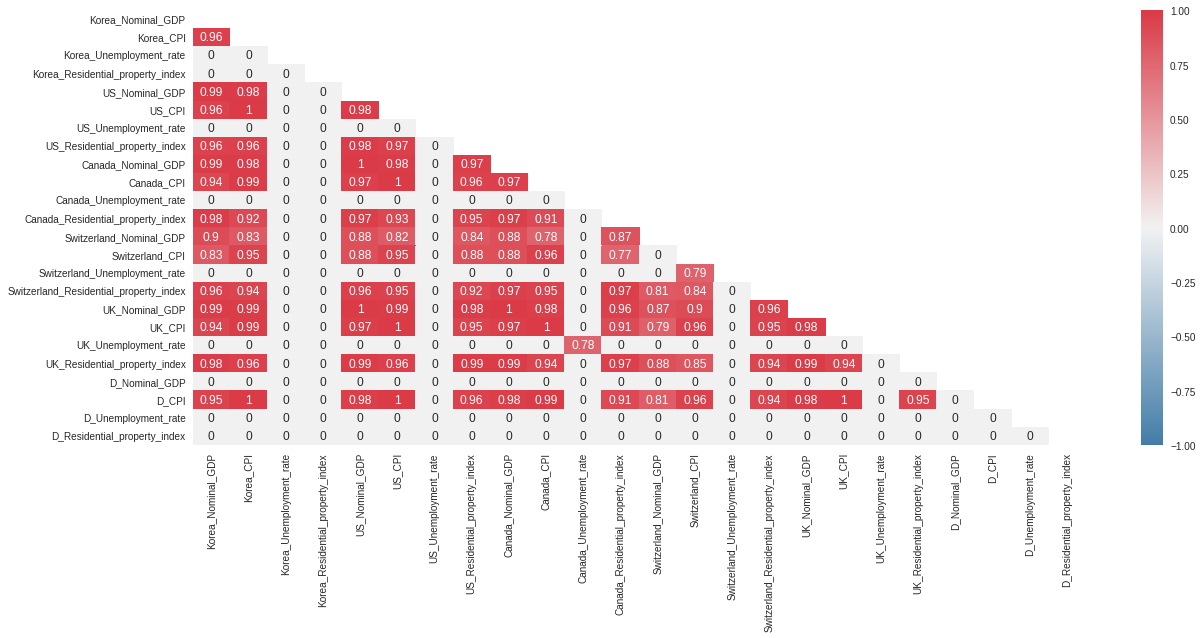

In [139]:
corr = mev_imputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

corr[abs(corr) <= 0.75] = 0

plt.figure(figsize=(20,8))
sns.heatmap(
    corr,
    mask = mask,
    vmin = -1,
    vmax = 1,
    cmap = cmap,
    annot = True
);

# Multiple Regression

**Predicting US GDP by other MEVs**

In [152]:
y = mev_imputed['US_Nominal_GDP']
X = mev_imputed.drop(columns = ['US_Nominal_GDP','Date'])

# 20% of 188 rows for validation, I chose not to have 3 splits due to data size 
test_size = 38

# Spliting time series datasets
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

**Linear Regression**

In [153]:
pipe = Pipeline(steps = [("standard_scale", StandardScaler()),
                         ("modeling", LinearRegression())])

pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)

# Metrics
print('MAE', metrics.mean_absolute_error(y_test, pred))
print('MSE', metrics.mean_squared_error(y_test, pred))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R2 Score', metrics.r2_score(y_test, pred))

MAE 262.95456632944644
MSE 140096.67868748063
RMSE 374.29490871167434
R2 Score 0.9652995151661541


In [154]:
# Coefficients ranking

model = pipe['modeling']

pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': model.coef_
}).sort_values(by=['Coef'], ascending=False)

,Feature,Coef
0,Korea_Nominal_GDP,1326.311522
7,Canada_Nominal_GDP,1101.158652
6,US_Residential_property_index,639.682250
15,UK_Nominal_GDP,629.320251
4,US_CPI,557.071805
16,UK_CPI,336.096322
20,D_CPI,260.262902
14,Switzerland_Residential_property_index,206.948616
12,Switzerland_CPI,117.996635
11,Switzerland_Nominal_GDP,52.740571


**Regularization**

In [155]:
from sklearn.linear_model import Lasso

In [156]:
# Lasso

sc = StandardScaler()
lasso_regr = Lasso()

pipeline_lasso = Pipeline([("data_scaling", sc),
                           ("estimator", lasso_regr)])


pipeline_lasso.fit(X_train, y_train)


pred_lasso = pipeline_lasso.predict(X_test)

print('MAE', metrics.mean_absolute_error(y_test, pred_lasso))
print('MSE', metrics.mean_squared_error(y_test, pred_lasso))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, pred_lasso)))
print('R2 Score', metrics.r2_score(y_test, pred_lasso))

MAE 605.9015262102508
MSE 544403.8044758186
RMSE 737.837247959073
R2 Score 0.8651568606930201


In [157]:
# Coefficient ranking

coefs = pipeline_lasso.named_steps["estimator"].coef_
pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': coefs
}).sort_values(by=['Coef'], ascending=False)

,Feature,Coef
0,Korea_Nominal_GDP,1325.723490
4,US_CPI,950.416377
6,US_Residential_property_index,762.182140
7,Canada_Nominal_GDP,561.556075
1,Korea_CPI,499.242230
14,Switzerland_Residential_property_index,196.091383
11,Switzerland_Nominal_GDP,110.741929
2,Korea_Unemployment_rate,38.275610
17,UK_Unemployment_rate,26.276891
19,D_Nominal_GDP,23.785840


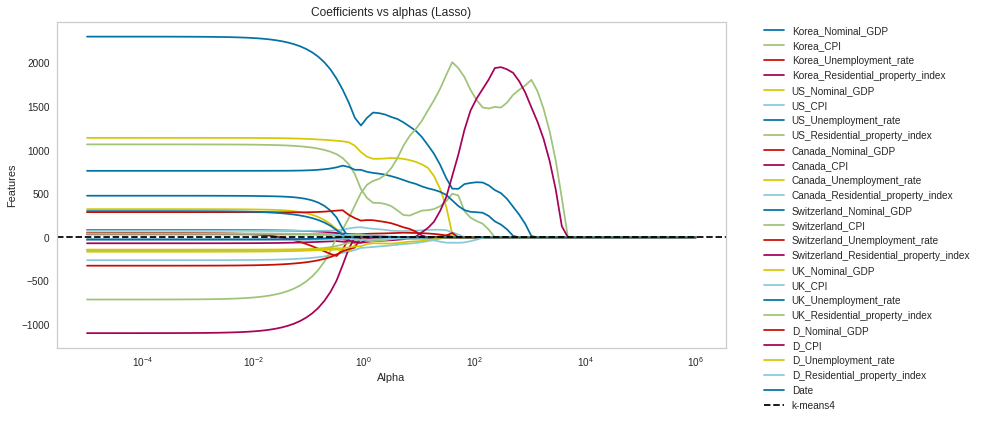

In [158]:
alphas = np.logspace(-5, 6, num=101)


coefs = []
rscore_test = []
rscore_train = []

for a in alphas:
    pipeline_lasso.set_params(estimator__alpha=a)
    pipeline_lasso.fit(X_train, y_train)
    rscore_train.append(pipeline_lasso.score(X_train, y_train))
    coefs.append(pipeline_lasso.named_steps["estimator"].coef_)
    rscore_test.append(pipeline_lasso.score(X_test, y_test))




# Visualizing the effect of different alpha
plt.subplots(figsize=[12,6])
plt.plot(alphas, coefs)
plt.xscale("log")    # we apply log scale to have a better view
plt.title("Coefficients vs alphas (Lasso)")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Alpha")
plt.ylabel("Features")
plt.legend(labels=mev_imputed.columns[:-1], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(False);

# Decision Tree Regressor

In [159]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [160]:
dt_regr = DecisionTreeRegressor()

dt_regr.fit(X_train, y_train)

dt_pred = dt_regr.predict(X_test)

print('MAE', metrics.mean_absolute_error(y_test, dt_pred))
print('MSE', metrics.mean_squared_error(y_test, dt_pred))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, dt_pred)))
print('R2 Score', metrics.r2_score(y_test, dt_pred))

MAE 3280.1890263157898
MSE 14614440.241189925
RMSE 3822.88375983235
R2 Score -2.619844286785911


In [161]:
# Feature importance ranking

for importance, name in sorted(zip(dt_regr.feature_importances_, X_train.columns),reverse=True):
  print (name, importance)

Canada_Nominal_GDP 0.7683889097192113
UK_Residential_property_index 0.09422930725897875
US_CPI 0.08779093132180067
Canada_CPI 0.02291300638468099
UK_Unemployment_rate 0.007690441588326044
Korea_CPI 0.006125155308208097
Korea_Nominal_GDP 0.004004636691474011
Switzerland_CPI 0.0024154292888577907
US_Residential_property_index 0.001630600390709709
D_Residential_property_index 0.0012840781698045395
D_CPI 0.0011445415675659482
UK_Nominal_GDP 0.0005468156450870212
UK_CPI 0.0004740358501109603
Switzerland_Unemployment_rate 0.0004388119800847252
Korea_Unemployment_rate 0.00029144973622183083
US_Unemployment_rate 0.00025681514112772195
Canada_Unemployment_rate 0.00011103664266668647
Korea_Residential_property_index 0.0001011771487911287
D_Unemployment_rate 5.66188374641532e-05
Switzerland_Residential_property_index 5.362162737079544e-05
Switzerland_Nominal_GDP 4.133936236639793e-05
k-means4 7.286527127651916e-06
Canada_Residential_property_index 3.953811963019247e-06
k-means3 0.0
D_Nominal_GDP 

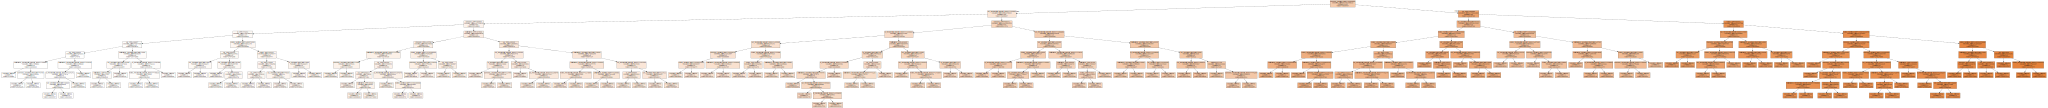

In [162]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt_regr, feature_names=list(X), class_names=sorted(y.unique()), filled=True)
graphviz.Source(dot_data)

#End